In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import dependencies

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.12.12
Tensorflow version: 2.19.0
Keras version: 3.10.0


# Configuring Tensorboard
We will use Tensorboard to debug the model later.

In [ ]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs.
!rm -rf ./.logs/

# Load the data

In [ ]:
# Import kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")

print("Path to dataset files:", path)

# The downloaded dataset contains two folders: 'training_set' and 'test_set'
# Each folder contains 'cats' and 'dogs' subfolders with the images.
# We need to load these images and their labels.

# Using image_dataset_from_directory to load images
image_size = (128, 128) # Increased image size for better clarity

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{path}/training_set/training_set',
    labels='inferred',
    label_mode='binary',  # Use 'binary' for binary classification (cat or dog)
    image_size=image_size,
    interpolation='nearest',
    batch_size=32,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{path}/test_set/test_set',
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=32,
    shuffle=False # No need to shuffle test data
)

# Convert datasets to numpy arrays for compatibility with subsequent code
# This step might be memory intensive for large datasets
x_train, y_train = [], []
for images, labels in train_ds.unbatch().as_numpy_iterator():
    x_train.append(images)
    y_train.append(labels)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = [], []
for images, labels in test_ds.unbatch().as_numpy_iterator():
    x_test.append(images)
    y_test.append(labels)
x_test = np.array(x_test)
y_test = np.array(y_test)


print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Using Colab cache for faster access to the 'cat-and-dog' dataset.
Path to dataset files: /kaggle/input/cat-and-dog
Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.
Shape of x_train: (8005, 128, 128, 3)
Shape of y_train: (8005, 1)
Shape of x_test: (2023, 128, 128, 3)
Shape of y_test: (2023, 1)


In [ ]:
# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(_, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) = x_train.shape

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 128
IMAGE_HEIGHT: 128
IMAGE_CHANNELS: 3


# Explore the data

In [ ]:
# Display a single row of the image data in a DataFrame
pd.DataFrame(x_train[0][0])

,0,1,2
0,127,141,141
1,133,147,147
2,125,135,136
3,134,142,144
4,139,150,154
...,...,...,...
123,28,32,31
124,0,4,3
125,3,3,3
126,4,2,3


This matrix of numbers may be drawn as follows:

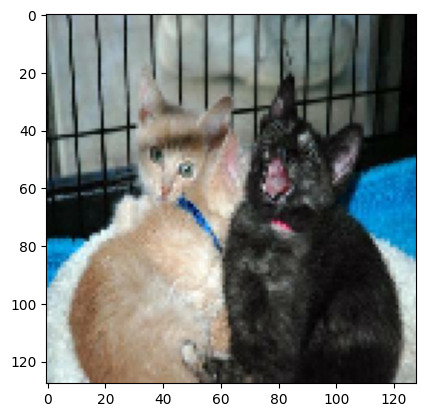

In [ ]:
plt.imshow(x_train[0])
plt.show()

Let's print some more training examples to get the feeling of how the digits were written.

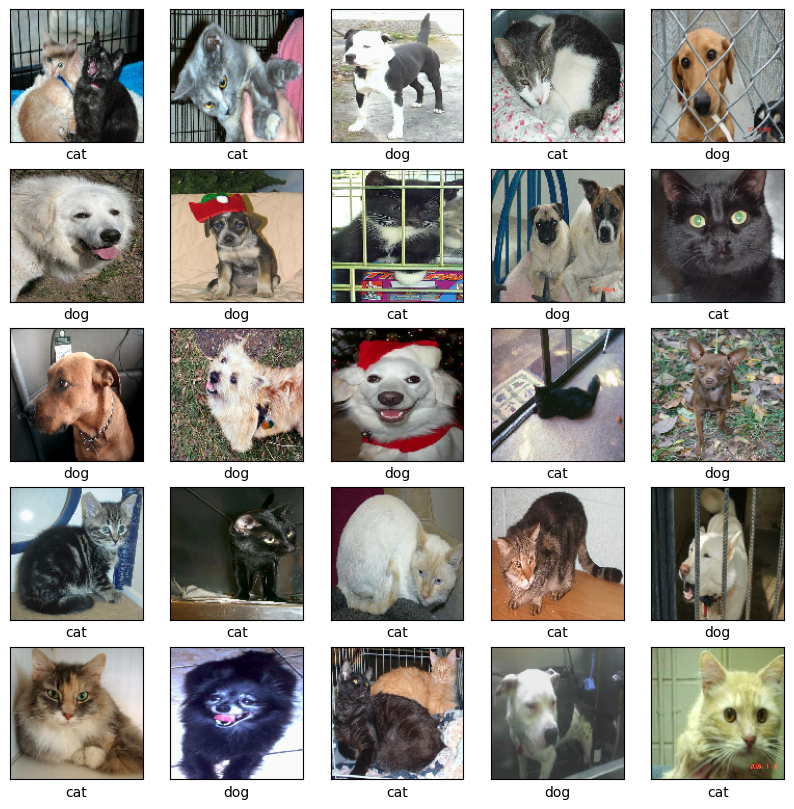

In [ ]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # Map the label back to 'cat' or 'dog' for display
    label = 'cat' if y_train[i] == 0 else 'dog'
    plt.xlabel(label)
plt.show()

# Reshaping the data

In [ ]:
print("Original shape of x_train:", x_train.shape)
print("Original shape of x_test:", x_test.shape)

Original shape of x_train: (8005, 128, 128, 3)
Original shape of x_test: (2023, 128, 128, 3)


In [ ]:
# Although the data is already in the desired shape for this dataset,
# this code demonstrates how you would reshape it if needed.
x_train_with_chanels = x_train.reshape(
    x_train.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test.reshape(
    x_test.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

print("Shape of x_train after (no-op) reshaping:", x_train_with_chanels.shape)
print("Shape of x_test after (no-op) reshaping:", x_test_with_chanels.shape)

# Normalize the data

In [ ]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255

In [ ]:
# Let's check just one row from the 0th image to see color chanel values after normalization.
x_train_normalized[0][18]

array([[0.2627451 , 0.32941176, 0.30588235],
       [0.38823529, 0.4745098 , 0.4627451 ],
       [0.63137255, 0.7254902 , 0.73333333],
       [0.57647059, 0.64313725, 0.6745098 ],
       [0.52941176, 0.59607843, 0.62745098],
       [0.5372549 , 0.61176471, 0.63529412],
       [0.54117647, 0.61176471, 0.61960784],
       [0.56078431, 0.60392157, 0.61960784],
       [0.2627451 , 0.29803922, 0.27843137],
       [0.32941176, 0.37647059, 0.36078431],
       [0.58039216, 0.63529412, 0.63529412],
       [0.56862745, 0.62352941, 0.62745098],
       [0.56470588, 0.62745098, 0.62352941],
       [0.56078431, 0.62352941, 0.61960784],
       [0.58039216, 0.64313725, 0.63921569],
       [0.60784314, 0.67058824, 0.66666667],
       [0.60392157, 0.65882353, 0.67058824],
       [0.59215686, 0.63137255, 0.63921569],
       [0.02352941, 0.0627451 , 0.07058824],
       [0.65098039, 0.70588235, 0.74117647],
       [0.64313725, 0.72156863, 0.76470588],
       [0.63921569, 0.70980392, 0.76470588],
       [0.

# Build the model

In [ ]:
# Load the ResNet50 model without the top classification layer
# Include_top=False removes the final fully connected layer
# weights='imagenet' loads the pre-trained weights from ImageNet
# input_shape specifies the expected input shape
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
)

# Freeze the layers of the base model so they are not updated during training
# for layer in base_model.layers:
#     layer.trainable = False

# First, unfreeze the entire base model
# base_model.trainable = True

# Create a new model with a different top.
# This example adds an extra Dense layer.
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu)(x) # Increased units
x = tf.keras.layers.Dropout(0.3)(x) # Adjusted dropout rate
predictions = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)(x)

# Create the new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 31,976,833 (121.98 MB)

 Trainable params: 31,923,713 (121.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Compile the model

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Train the model

In [ ]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train,
    epochs=10,
    validation_data=(x_test_normalized, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 288ms/step - accuracy: 0.8746 - loss: 0.3916 - val_accuracy: 0.4978 - val_loss: 0.8176
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9862 - loss: 0.0406 - val_accuracy: 0.5017 - val_loss: 0.9656
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 168ms/step - accuracy: 0.9929 - loss: 0.0202 - val_accuracy: 0.7790 - val_loss: 0.5589
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9923 - loss: 0.0278 - val_accuracy: 0.9293 - val_loss: 0.2316
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.9816 - loss: 0.0570 - val_accuracy: 0.9362 - val_loss: 0.2263
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 168ms/step - accuracy: 0.9863 - loss: 0.0495 - val_accuracy: 0.9530 - val_loss: 0.2069
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.9955 - loss: 0.0153 - val_accuracy: 0.9575 - val_loss: 0.1876
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 168ms/step - accuracy: 0.9991 - loss: 

Let's see how the loss function was changing during the training. We expect it to get smaller and smaller on every next epoch.

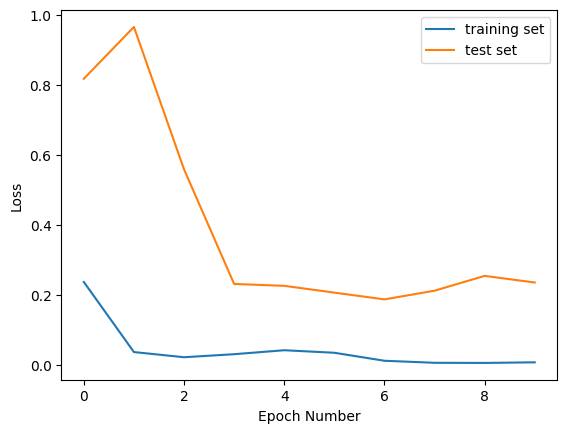

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='test set')
plt.legend()

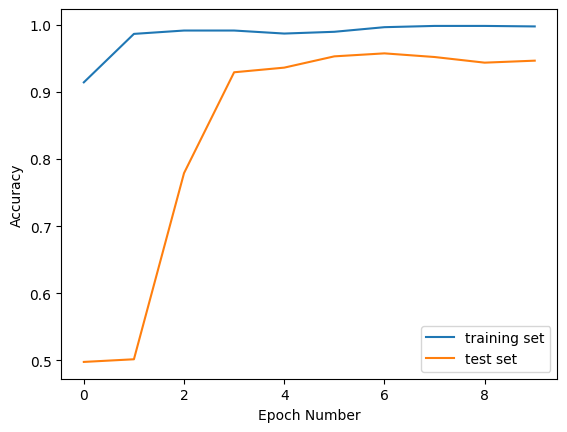

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='test set')
plt.legend()

# Evaluate model accuracy
Training set accuracy

In [ ]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)

In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)

Training loss:  0.004226671066135168
Training accuracy:  0.9983760118484497


Test set accuracy

In [ ]:
%%capture
validation_loss, validation_accuracy = model.evaluate(x_test_normalized, y_test)

In [ ]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

Validation loss:  0.23572690784931183
Validation accuracy:  0.9466139674186707


In [ ]:
model_name = 'cat_dog_resnet101.h5'
model.save(model_name, save_format='h5')

In [ ]:
loaded_model = tf.keras.models.load_model(model_name)

# Use the model (do predictions)
To use the model that we've just trained for digits recognition we need to call predict() method.

In [ ]:
predictions_one_hot = loaded_model.predict([x_test_normalized])

64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step


In [ ]:
print('predictions_one_hot:', predictions_one_hot.shape)

predictions_one_hot: (2023, 1)


In [ ]:
# Predictions in form of one-hot vectors (arrays of probabilities).
pd.DataFrame(predictions_one_hot)

,0
0,1.173135e-03
1,1.532979e-03
2,3.248098e-12
3,5.241765e-11
4,2.341759e-12
...,...
2018,9.998478e-01
2019,1.000000e+00
2020,3.186052e-04
2021,9.999994e-01


In [ ]:
# Let's extract predictions based on the sigmoid output threshold (0.5).
# If probability > 0.5, predict dog (label 1), otherwise predict cat (label 0).
predictions = (predictions_one_hot > 0.5).astype(int)
# Flatten the predictions to be a 1D array
predictions = predictions.flatten()
pd.DataFrame(predictions)

,0
0,0
1,0
2,0
3,0
4,0
...,...
2018,1
2019,1
2020,0
2021,1


In [ ]:
print(predictions[0])

0


Let's print the first image from a test set to see if model's prediction is correct

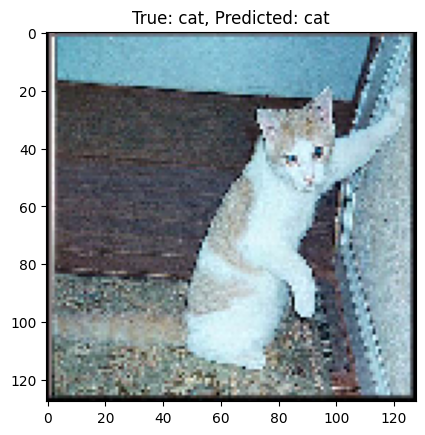

In [ ]:
# Map the label back to 'cat' or 'dog' for display
true_label = 'cat' if y_test[0] == 0 else 'dog'
predicted_label = 'cat' if predictions[0] == 0 else 'dog'

plt.imshow(x_test_normalized[0])
plt.title(f"True: {true_label}, Predicted: {predicted_label}")
plt.show()

Let's print some more test examples and correspondent predictions to see how model performs and where it does mistakes.


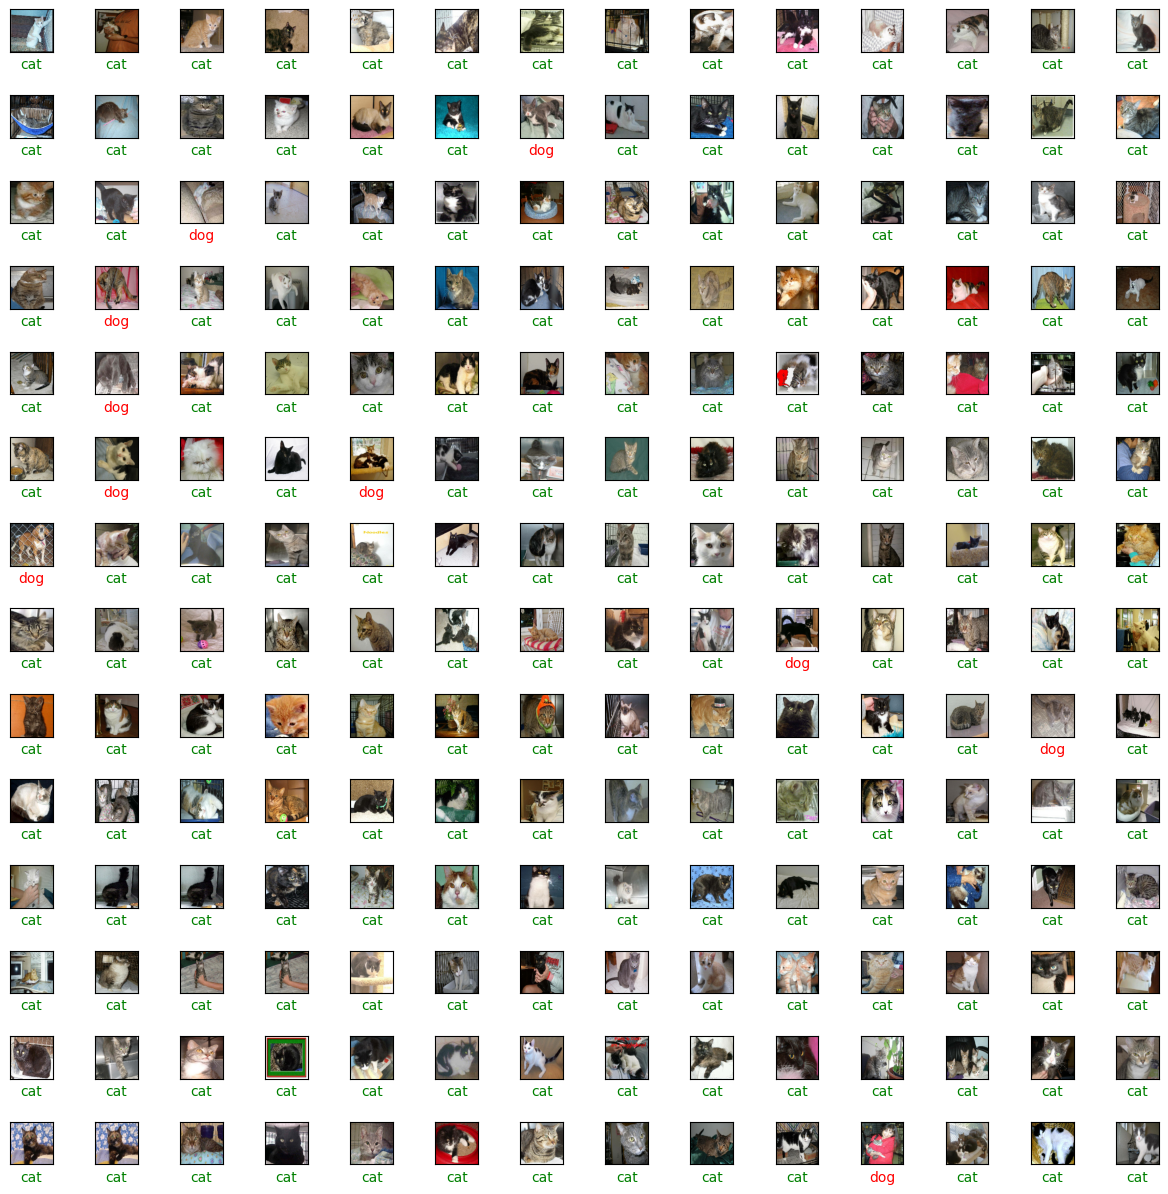

In [ ]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label_numeric = predictions[plot_index]
    true_label_numeric = y_test[plot_index]

    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Use the normalized image directly, no reshape needed for color images
    plt.imshow(x_test_normalized[plot_index])

    # Determine label text and color
    predicted_label_text = 'cat' if predicted_label_numeric == 0 else 'dog'
    color = 'green' if predicted_label_numeric == true_label_numeric else 'red'

    plt.xlabel(predicted_label_text, color=color)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

# Plotting a confusion matrix

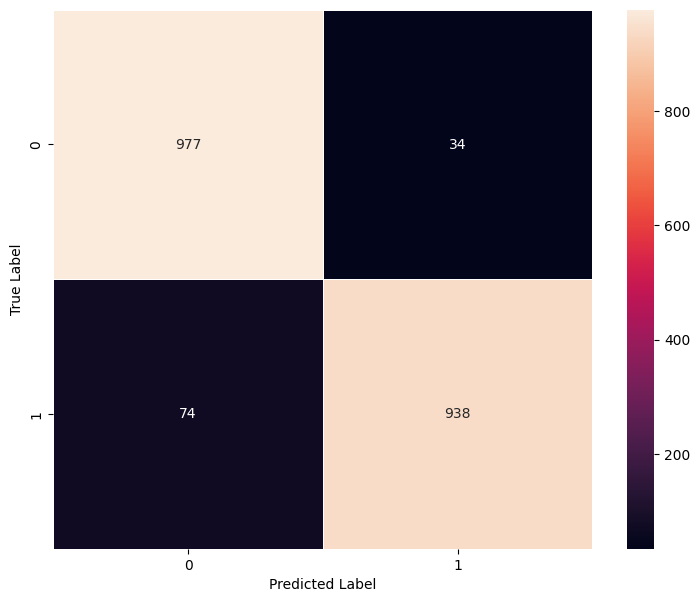

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()